# Time Series Methods: Forecasting

Forecasting is one of many modeling approaches applied to time series datasets. In this tutorial series, we will focus on forecasting techniques.

In this notebook, we will cover:

1. What is Forecasting?
2. How do we evaluate forecasting methods?
3. How do we split the train-test time series?
4. How can we use GluonTS to form our train-test splits? This will be useful in later notebooks when using machine learning models from GluonTS.
5. What are the evaluation metrics for forecasting?

## Basics

**Forecasting:** Given a time series of $ T $ time points, forecasting aims to predict the next $ F $ future time points, where $ F $ is the forecasting horizon.

**Evaluation of Forecasting Methods:** To evaluate forecasting methods, we split the dataset into training, validation, and testing sets. The validation set is used for hyperparameter tuning, while the test set is used to report the final performance metrics.

*Note:* In machine learning, the dataset is split into train, validation, and test sets. The validation set is used to select hyperparameters, while the test set is reserved for final evaluation.

**Splitting Time Series Datasets:** Time series datasets are different from traditional datasets due to their chronological ordering. Traditional datasets are often split randomly into train, validation, and test sets. However, time series datasets must be split chronologically.

We train estimators using data up to a certain point. We evaluate these estimators on the future data using a rolling window approach, where historical data expands, and/or the prediction window shifts forward.

## Setup

We will load `m4` dataset we analyzed in `01.1_datasets-univariate-eda.ipynb`. We will use GluonTS used in the previous notebook to do so. 

In [4]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import json

from gluonts.dataset.common import ListDataset

import utils_tfb # contains the function to read/preprocess the datasets as provided by the authors

TS_DATA_FOLDER = pathlib.Path("./forecasting").resolve() # Data folder

random.seed(14)

In [3]:
dataset_name = "m4_monthly_dataset_43531.csv"
dataset = TS_DATA_FOLDER / dataset_name
data = utils_tfb.read_data(dataset)
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (199, 1)


,channel_1
date,
1998-12-31 12:00:00,4155.7457
1999-01-31 12:00:00,4291.8389
1999-02-28 12:00:00,4168.7291
1999-03-31 12:00:00,4470.3329
1999-04-30 12:00:00,4710.2099


In [7]:
freq = 'M' # CSV doesn't stor freq metadata, as  a result, we need to specify it manually
start = pd.Period(data.index[0], freq=freq)
prediction_length = 12
rolling_windows = 4

train_ds = ListDataset(
    [{
        "target": data['channel_1'].values[:-rolling_windows*prediction_length], "start": start
    }],
    freq=freq
)

test_ds = ListDataset(
    [
        {
            "target": data['channel_1'].values[:-(rolling_windows - x - 1) * prediction_length], "start": start
        } 
    for x in range(rolling_windows)],
    freq=freq
)

### Visualizating Rolling/Expanding Window

In this section, we will plot the training and test datasets using the rolling/expanding window approach.

**Training data** is Used to build the estimator. **Test Data** is used to measure the performance.

By visualizing these datasets, we can better understand how the rolling/expanding window technique applies to time series forecasting.

Number of rolling evaluations: 4


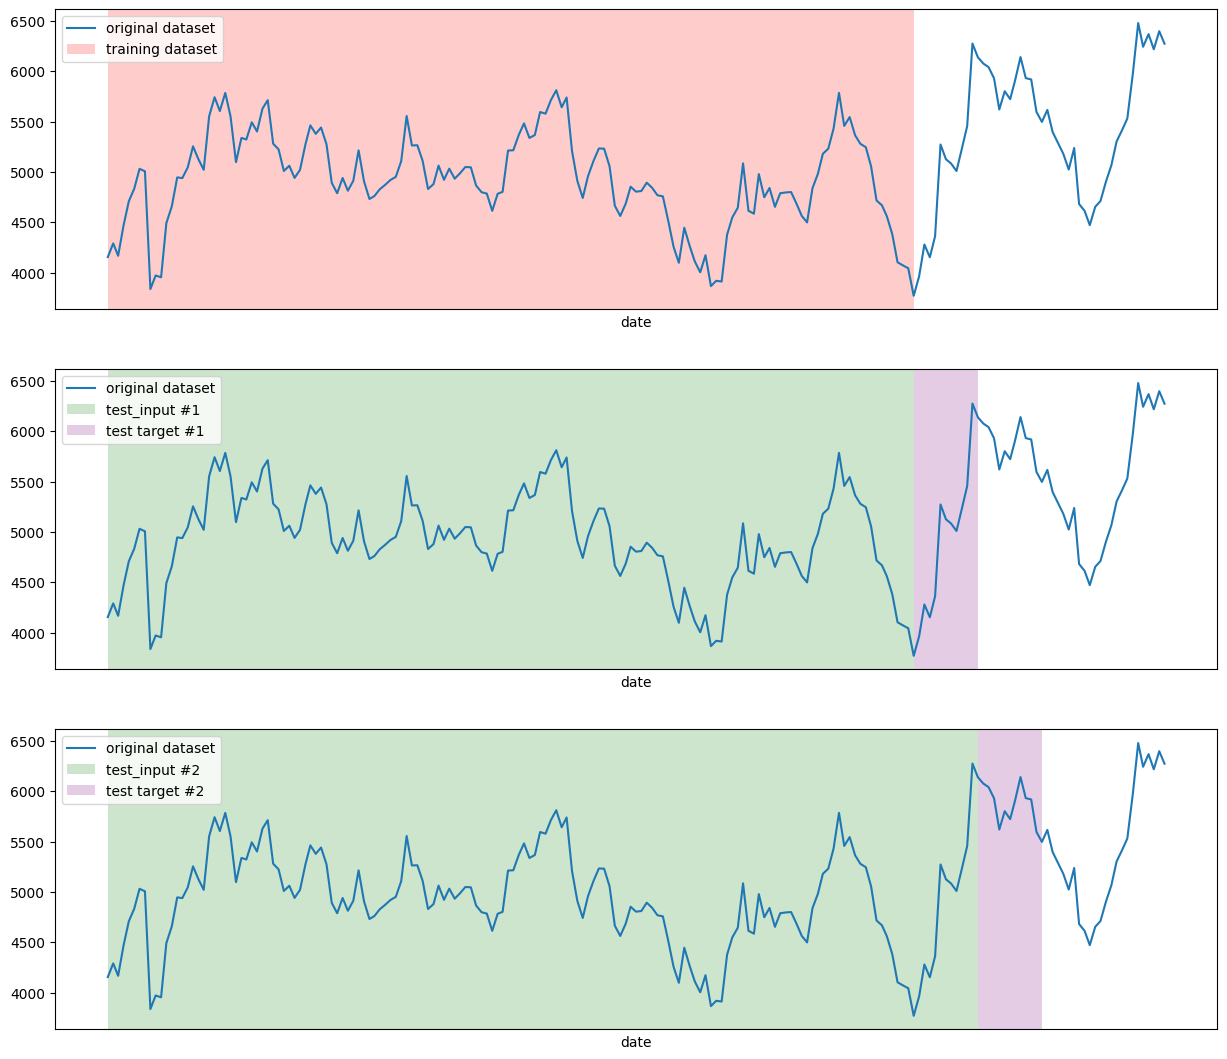

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(15, 15))

ax = axs[0]
train_series = next(iter(train_ds))
data['channel_1'].plot(ax=ax)

ax.axvspan(train_series['start'], train_series['start'] + len(train_series['target']), facecolor='red', alpha=0.2)
ax.legend(['original dataset', 'training dataset'], loc='upper left')
ax.set_xticks([])

print(f"Number of rolling evaluations: {len(test_ds)}")
for idx, test_series in enumerate(test_ds):
    if idx + 1 > len(axs) - 1:
        break
        
    ax = axs[idx+1]    
    data['channel_1'].plot(ax=ax)

    test_input_end = test_series['start'] + len(test_series['target']) - prediction_length
    test_output_end = test_series['start'] + len(test_series['target'])
    
    ax.axvspan(test_series['start'], test_input_end, facecolor='green', alpha=0.2)
    
    ax.axvspan(test_input_end, test_output_end, facecolor='purple', alpha=0.2)
    ax.legend(['original dataset', f'test_input #{idx+1}', f'test target #{idx+1}'],  loc='upper left')

    ax.set_xticks([])

## GluonTS for Train-Test Splitting

In GluonTS, we can import a pandas time series dataset and split it using the `PandasDataset` class. Here are the steps to specify how to split a dataset:

1. Convert your pandas dataset into a `PandasDataset`, the internal format used by GluonTS.
2. Utilize the `gluonts.dataset.split` module to create iterables for the training and testing sets.
3. Indicate the index up to which you want to define the training dataset.
4. Define the prediction length and the rolling windows. This allows the function to partition the original dataset into incremental windows, with each window being `prediction_length` longer than the previous one.

In [9]:
from gluonts.dataset.split import split
from gluonts.dataset.pandas import PandasDataset

gluon_data = PandasDataset(data, target='channel_1', freq='M')
gluon_data

PandasDataset<size=1, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [10]:
prediction_length = 12
windows=4

data_pd = PandasDataset(data, target='channel_1', freq='M')
training_dataset, test_template = split(
    data_pd, date=pd.Period(data.index[100], freq='M')
)

test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=windows,
    distance = 10
)

In [11]:
train_data = next(iter(training_dataset))
train_data


{'start': Period('1998-12', 'M'),
 'target': array([4155.7457, 4291.8389, 4168.7291, 4470.3329, 4710.2099, 4835.5007,
        5032.3649, 5007.5267, 3838.4659, 3973.4189, 3955.1274, 4493.7378,
        4659.2449, 4947.2098, 4939.9885, 5046.617 , 5255.2305, 5126.9353,
        5022.0765, 5554.0181, 5742.9799, 5605.7008, 5785.9991, 5551.9266,
        5098.5899, 5338.9005, 5323.4925, 5493.9295, 5403.0431, 5629.4915,
        5713.7984, 5281.5766, 5224.7074, 5010.6274, 5062.4733, 4941.8686,
        5021.6112, 5274.7413, 5463.5064, 5379.3428, 5442.106 , 5276.083 ,
        4892.8041, 4789.6159, 4941.1461, 4814.3644, 4914.6456, 5215.7212,
        4908.698 , 4732.4781, 4761.7008, 4829.5664, 4872.6725, 4921.7876,
        4951.8868, 5107.9436, 5556.66  , 5264.0633, 5266.2392, 5112.4405,
        4831.8446, 4880.1105, 5063.9656, 4923.3067, 5033.7055, 4934.0815,
        4987.3658, 5050.4966, 5047.0662, 4866.6906, 4800.1628, 4786.3413,
        4615.0125, 4784.479 , 4803.3879, 5213.5322, 5216.2612, 5367.

In [12]:
print("# of time steps in train data ", train_data['target'].shape)

idx = 0
for test_series, test_label in iter(test_pairs):
    print(f"# of time steps in test input {idx+1}", test_series['target'].shape, test_label['target'].shape)
    idx += 1

# of time steps in train data  (101,)
# of time steps in test input 1 (101,) (12,)
# of time steps in test input 2 (111,) (12,)
# of time steps in test input 3 (121,) (12,)
# of time steps in test input 4 (131,) (12,)


We see that GluonTS efficiently separates the training dataset into input-label pairs suitable for evaluating an estimator.

This brings us to an important question:

**What are the evaluation metrics for time series forecasting?**


## Evaluation Metrics for Time Series Forecasting

When evaluating time series forecasting models, several statistical metrics are used to assess accuracy and effectiveness. Assuming we have a time series with a total duration $ T $ and a forecasting horizon $ F $. The actual values are $ Y \in \mathbb{R}^T $, and the forecasted values for a future period are $ \hat{Y}_{T+k} $, where $ k \in \{1, 2, \ldots, F\} $. Here are more detailed descriptions and clarifications for the listed metrics:

1. **Mean Absolute Error (MAE)**: MAE measures the average magnitude of the errors in the predictions, ignoring their direction. It gives a linear scale of errors, making it easy to interpret.

$$
     \text{MAE} = \frac{1}{F} \sum_{k=1}^{F} |\hat{Y}_{T+k} - Y_{T+k}|
$$

2. **Mean Squared Error (MSE)**: MSE provides a square scale of the errors to penalize larger errors more than smaller ones, which can be significant when large errors are particularly undesirable in your application.

$$
     \text{MSE} = \frac{1}{F} \sum_{k=1}^{F} (\hat{Y}_{T+k} - Y_{T+k})^2
$$

3. **Root Mean Squared Error (RMSE)** RMSE is essentially the square root of MSE, which adjusts the scale back to the original units of the data, making interpretation straightforward.

$$
     \text{RMSE} = \sqrt{\frac{1}{F} \sum_{k=1}^{F} (\hat{Y}_{T+k} - Y_{T+k})^2}
$$

4. **Mean Absolute Scaled Error (MASE)**: MASE scales the MAE by the MAE of a naive model. This scaling makes MASE an error measure that is independent of the data's scale, providing a context of how well the model performs relative to a simple baseline.

A naive MAE is defined over the historical data, not the forecasting period. It typically uses the last observation as the forecast for the next one, or the last seasonally observed value if the data exhibits seasonality. 

$$
     \text{MASE} = \frac{\text{MAE}}{\text{MAE}_{\text{naive}}}
$$

$$
\text{MAE}_{\text{naive}} = \frac{1}{T - 1}\sum_{t=2}^{T} \mid Y_{t - 1} - Y_{t} \mid
$$


$$
     \text{MASE} = \frac{\sum_{k=1}^{F} |\hat{Y}_{T+k} - Y_{T+k}|}{\frac{1}{T - 1}\sum_{t=2}^{T} \mid Y_{t - 1} - Y_{t} \mid}
$$

**Notes**

- MASE is particularly useful because it allows comparisons across different datasets and is not dependent on the scale of the data, making it ideal for benchmarks and comparisons between different forecasting models.

- It's important to consider the characteristics of your data and the specific requirements of your forecasting problem when choosing the appropriate metric(s) for evaluation.

### Simple Evalaution
Several functions to compute the above metrics are provided in utils.py. Let's look at a rough example of how to use the MASE metric. You are encouraged to read the code in utils.py to understand how these metrics work.

MASE: 3.271226577566426


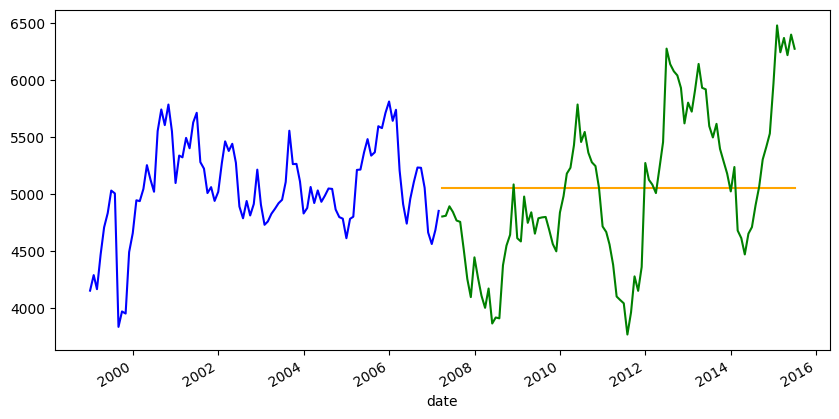

In [27]:
import utils
insample_data = data['channel_1'][:-100]

test_data = data['channel_1'][-100:]
forecast = pd.Series(np.ones_like(test_data) * insample_data.mean(), index=test_data.index)


fig, ax = plt.subplots(figsize=(10,5), dpi=100)
insample_data.plot(ax=ax, color='blue')
forecast.plot(ax=ax, color='orange')
test_data.plot(ax=ax, color='green')


print("MASE:", utils.mean_absolute_scaled_error(forecast, test_data.values, insample_data.values))

## Next Steps

Let's build some statistical forecasting methods for time series. Proceed to the following notebooks:

1. `03.1_classical_models_exploration.ipynb`: Contains exploratory analysis of the time series dataset that we will use throughout the tutorial.
2. `03.2_classical_models.ipynb`: Contains the implementation of the statistical forecasting models.
